In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# 1. Clases para construir Bases Bspline

In [2]:
class Bases_curves:
    def __init__(self, t=None):
        self.t = t if t is not None else [0, 1, 2, 3, 4]

    def N_0(self, i, u):
        if i <= len(self.t) - 2:
            return 1 if (self.t[i] <= u < self.t[i + 1]) else 0
        return 'El índice ha sobrepasado los límites'

    def N_p(self, i, u, p):
        n = len(self.t)
        if p > n - 2 or i > n - p - 2:
            return f'Ingrese valores de i=[0, {n - p - 2}] y p=[0, {n - 2}]'

        if p == 0:
            return self.N_0(i, u)

        denom1 = self.t[i + p] - self.t[i]
        denom2 = self.t[i + p + 1] - self.t[i + 1]

        term1 = ((u - self.t[i]) / denom1 * self.N_p(i, u, p - 1)) if denom1 != 0 else 0
        term2 = ((self.t[i + p + 1] - u) / denom2 * self.N_p(i + 1, u, p - 1)) if denom2 != 0 else 0

        return term1 + term2

Ejemplo de uso.   
La variable **t** almacena los nodos, **p** es el grado de la curva y **u** el valor del parámetro.

In [3]:
Bases_curves(t=[0,1,2,3,4,5]).N_p(i=0, u=0.5, p=4)

0.0026041666666666665

# 2. Clase para construir puntos de la curva NURBS

In [4]:
class Nurbs_curbs:
    def __init__(self):
        pass

    def curva(self, pts, pes, nod, p, u):
        bc = Bases_curves(nod)  
        dim = len(pts[0])
        suma_den = 0.0
        suma_num = [0.0] * dim

        for i in range(len(pes)):
            Ni = bc.N_p(i, u, p)  
            mNi = pes[i] * Ni

            suma_den += mNi
            for d in range(dim):
                suma_num[d] += mNi * pts[i][d]

        if suma_den == 0:
            return [0.0] * dim
        return [coord / suma_den for coord in suma_num]

    def curva1(self, pts, pes, nod, p, u):
        if isinstance(u, (int, float)):
            return self.curva(pts, pes, nod, p, u)
        elif isinstance(u, (list, np.ndarray)):
            return [self.curva(pts, pes, nod, p, val) for val in u]
        else:
            raise ValueError("La entrada debe ser un número o un array de NumPy.")

Ejemplo de uso.  
Primero se define los puntos de control, los pesos para cada punto y el vector de los nodos con su grado de la curva. Mediante el método **curva1** de la clase **Nurbs_curbs** se obtiene los puntos de la curva, donde: **pts** son para los puntos de control, **pes** para los pesos, **nod** para los nodos, **p** para el grado de la curva, y **u** para los valores del parámetro ingresados como lista unidimensional.

In [5]:
puntos_control = [[1, 0],[1, np.sqrt(3)],[-1/2, np.sqrt(3)/2],[-2, 0],[-1/2, -np.sqrt(3)/2],[1, -np.sqrt(3)],[1, 0]]
peso = [1, 1/2, 1, 1/2, 1, 1/2, 1]
nodos = [0, 0, 0, 1, 1, 2, 2, 3, 3, 3]

In [6]:
Nurbs_curbs().curva1(pts=puntos_control, pes=peso, nod=nodos, p=2, u=np.linspace(0, 3, 5))

[[np.float64(1.0), np.float64(0.0)],
 [np.float64(-0.038461538461538464), np.float64(0.999260081289737)],
 [np.float64(-1.0), np.float64(0.0)],
 [np.float64(-0.038461538461538464), np.float64(-0.999260081289737)],
 [0.0, 0.0]]

# 3. Clase para definir pesos, nodos y puntos de la circunferencia

In [7]:
class Construccion:
    def __init__(self, n, r):
        self.n, self.r = n, r
        
    @property
    def polygon(self):
        θ = 2 * np.pi / self.n
        α = np.pi * (self.n - 2) / (2 * self.n)
        R = self.r / np.sin(α)
        
        lista = []
        for k in range(self.n):
            lista.append([self.r * np.cos(θ * k), self.r * np.sin(θ * k)])
            lista.append([R * np.cos(θ * (2 * k + 1) / 2), R * np.sin(θ * (2 * k + 1) / 2)])
        lista.append(lista[0])  
        return lista

    @property
    def peso(self):
        θ = 2 * np.pi / self.n
        lista = []
        for _ in range(self.n):
            lista.append(1)
            lista.append(np.cos(θ / 2))
        lista.append(1)  # cierre
        return lista

    @property
    def open1(self):
        lista = []
        for k in range(self.n + 1):
            lista.append(k)
            lista.append(k)
        lista = [0] + lista + [self.n]
        return lista

Ejemplo de uso.  
Se inicializa la clase **Construccion** simplemente ingresando el número de lados del polígono y su radio. Luego mediante **polygon** se obtiene los puntos de control de la circunferencia; con **peso** se obtiene los respestivos pesos de cada punto, y con **open1** se obtiene los nodos. 

In [8]:
objeto = Construccion(n=3, r=1)

In [9]:
objeto.polygon

[[np.float64(1.0), np.float64(0.0)],
 [np.float64(1.0000000000000004), np.float64(1.7320508075688776)],
 [np.float64(-0.4999999999999998), np.float64(0.8660254037844387)],
 [np.float64(-2.0000000000000004), np.float64(2.449293598294707e-16)],
 [np.float64(-0.5000000000000004), np.float64(-0.8660254037844385)],
 [np.float64(0.9999999999999989), np.float64(-1.7320508075688785)],
 [np.float64(1.0), np.float64(0.0)]]

In [10]:
objeto.peso

[1,
 np.float64(0.5000000000000001),
 1,
 np.float64(0.5000000000000001),
 1,
 np.float64(0.5000000000000001),
 1]

In [11]:
objeto.open1

[0, 0, 0, 1, 1, 2, 2, 3, 3, 3]

# 4. Graficar Circunferencias tipo NURBS

In [12]:
class Nurbs_circumference:
    def __init__(self, n, r, p=2): 
        self.n, self.r, self.p = n, r, p
        self.objeto1 = Nurbs_curbs()
        self.objeto2 = Construccion(self.n, self.r)
        self.u = np.linspace(min(self.objeto2.open1), max(self.objeto2.open1) - 1e-10, 100)

    def grafica(self, puntos=True):
        poly = np.array(self.objeto2.polygon, dtype=float)   # (N, 2)
        pesos = self.objeto2.peso
        nodos = self.objeto2.open1

        curvaw = np.array(self.objeto1.curva1(poly, pesos, nodos, self.p, self.u), dtype=float)  # (M, 2)

        values_x, values_y = curvaw[:, 0], curvaw[:, 1]
        pts_x, pts_y = poly[:, 0], poly[:, 1]

        plt.figure(figsize=(8, 6))
        plt.plot(values_x, values_y, color='blue')
        plt.plot(pts_x, pts_y, color='orange')
        plt.axis('equal')
        if puntos:
            plt.scatter(pts_x, pts_y, color='red')
        plt.show()

Ejemplo de uso

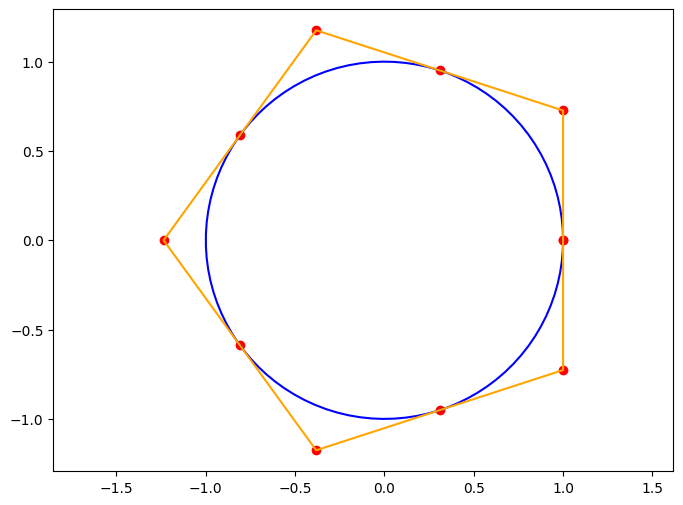

In [13]:
Nurbs_circumference(n=5, r=1).grafica(puntos=True)

# 5. Clase para construir puntos de la superficie NURBS

In [14]:
class Nurbs_surface:
    def __init__(self, pts1, pts2, pes1, pes2, nod1, nod2, p1, p2):
        self.pts1, self.pts2 = np.array(pts1, dtype=float), np.array(pts2, dtype=float)
        self.pes1, self.pes2 = np.array(pes1, dtype=float), np.array(pes2, dtype=float)
        self.nod1, self.nod2 = nod1, nod2
        self.p1, self.p2 = p1, p2
        self.objeto1, self.objeto2 = Bases_curves(t=self.nod1), Bases_curves(t=self.nod2)

    def W_ij(self, i, j):
        if i < len(self.pes1) and j < len(self.pes2):
            return self.pes1[i] * self.pes2[j]
        return None  # Evita strings en cálculos numéricos

    def P_ij(self, i, j):
        if i < len(self.pts1) and j < len(self.pts2):
            return [self.pts2[j][0] * self.pts1[i][0],
                    self.pts2[j][0] * self.pts1[i][1],
                    self.pts2[j][2]]
        return None

    def superficie(self, u, v):
        dim = self.pts1.shape[1]
        suma_den = 0.0
        suma_num = [0.0] * dim

        for i1 in range(len(self.pes1)):
            Ni = self.objeto1.N_p(i1, u, self.p1)
            for j1 in range(len(self.pes2)):
                Nj = self.objeto2.N_p(j1, v, self.p2)
                w_ij = self.W_ij(i1, j1)
                if w_ij is None:
                    continue
                factor = Ni * Nj * w_ij

                suma_den += factor
                P = self.P_ij(i1, j1)
                for k in range(dim):
                    suma_num[k] += factor * P[k]

        return [coord / suma_den for coord in suma_num]

    def procesar(self, u, v):
        if isinstance(u, (int, float)) and isinstance(v, (int, float)):
            return self.superficie(u, v)

        elif isinstance(u, np.ndarray) and isinstance(v, np.ndarray):
            if u.shape != v.shape:
                return 'Ingrese vectores con mismas dimensiones'

            fila, columna = u.shape
            dim = len(self.superficie(u[0][0], v[0][0]))
            lista_alm = [[] for _ in range(dim)]

            for i in range(fila):
                for j in range(columna):
                    B = self.superficie(u[i, j], v[i, j])
                    for k in range(dim):
                        lista_alm[k].append(B[k])

            return [np.array(psdr).reshape(fila, columna) for psdr in lista_alm]

        else:
            raise ValueError("La entrada debe ser un número o un array de NumPy.")

# 6. Gráfica de esferas y toros

In [ ]:
class Nurbs_superficie3D_graph:
    def __init__(self, pts1, pts2, pes1, pes2, nod1, nod2, p1, p2):
        self.pts1, self.pts2, self.pes1, self.pes2, self.nod1, self.nod2, self.p1, self.p2 = pts1, pts2, pes1, pes2, nod1, nod2, p1, p2
        self.u = np.linspace(min(self.nod1), max(self.nod1)-10**(-10), 40)
        self.v = np.linspace(min(self.nod2), max(self.nod2)-10**(-10), 40)
        self.U, self.V = np.meshgrid(self.u, self.v)
        self.objeto = Nurbs_surface(self.pts1, self.pts2, self.pes1, self.pes2, self.nod1, self.nod2, self.p1, self.p2)
        self.objeto1 = Nurbs_curbs()
    
    def grafica(self, pdir=True, pgen=True, c_pdir= True, c_pgen=True, enmaller=True, pts_ctrl=True, superficie=True):
        if superficie is True:    
            my_surface = self.objeto.procesar(u=self.U, v=self.V)
            X = my_surface[0]
            Y = my_surface[1]
            Z = my_surface[2]

        if enmaller is True:     
            Data = []
            for i in range(len(self.pts1)):
                l_dat = []
                for j in range(len(self.pts2)):
                    l_dat.append(self.objeto.P_ij(i, j))     
                Data.append(l_dat)
            Data = np.array(Data)
        
        def funci(lista):
            mi_lista = [[] for k in range(len(lista[0]))]
            for i in range(len(mi_lista)):
                mi_lista[i].append(np.array([k[i] for k in lista]))
            mi_lista = np.concatenate(np.array(mi_lista), axis=0)
            return mi_lista
            
        def funci1(matrix):
            columna = matrix.shape[1]
            lista_alm1 = [[] for k in range(columna)]
            for i in range(len(lista_alm1)):
                lista_alm1[i].append(matrix[: ,i])
            lista_alm1 = np.concatenate(np.array(lista_alm1), axis=0)
            return lista_alm1

        def grafica_maller(matrix):
            mi_lista1 = funci1(matrix)
            mi_lista2 = []
            for i in range(len(mi_lista1)):
                mi_lista2.append(funci(mi_lista1[i]))
            return mi_lista2
        
        if pts_ctrl is True:    
            mi_puntos = funci(np.concatenate(Data, axis=0))
        
        if pdir is True:    
            x_pdir = np.array([k[0] for k in self.pts1])
            y_pdir = np.array([k[1] for k in self.pts1])
            z_pdir = np.array([k[2] for k in self.pts1])
        if pgen is True:  
            x_pgen = np.array([k[0] for k in self.pts2])
            y_pgen = np.array([k[1] for k in self.pts2])
            z_pgen = np.array([k[2] for k in self.pts2])

        if c_pdir is True:  
            C_c1 = self.objeto1.curva1(pts=self.pts1, pes=self.pes1, nod=self.nod1, p=self.p1, u=self.u)
            my_c1 = funci(C_c1)
        if c_pgen is True:
            C_c2 = self.objeto1.curva1(pts=self.pts2, pes=self.pes2, nod=self.nod2, p=self.p2, u=self.v)
            my_c2 = funci(C_c2)

        fig = go.Figure()
        if pdir is True:
            fig.add_trace(go.Scatter3d(x=x_pdir, y=y_pdir, z=z_pdir, mode='lines', line=dict(color='black',width=6), showlegend=False))
        if pgen is True:
            fig.add_trace(go.Scatter3d(x=x_pgen, y=y_pgen, z=z_pgen, mode='lines', line=dict(color='black',width=6), showlegend=False))
        if c_pdir is True:
            fig.add_trace(go.Scatter3d(x=my_c1[0], y=my_c1[1], z=my_c1[2], mode='lines', line=dict(color='#FFD700',width=8), showlegend=False))
        if c_pgen is True:
            fig.add_trace(go.Scatter3d(x=my_c2[0], y=my_c2[1], z=my_c2[2], mode='lines', line=dict(color='#FFD700',width=8), showlegend=False))

        
        if enmaller is True:
            lista_graf = grafica_maller(Data)
            lista_graf1 = []
            for i in range(Data.shape[0]):
                lista_graf1.append(funci(Data[i, :]))
            for i in range(len(lista_graf)):
                fig.add_trace(go.Scatter3d(x=lista_graf[i][0], y=lista_graf[i][1], z=lista_graf[i][2], mode='lines', line=dict(color='blue'), showlegend=False))
            for i in range(len(lista_graf1)):
                fig.add_trace(go.Scatter3d(x=lista_graf1[i][0], y=lista_graf1[i][1], z=lista_graf1[i][2], mode='lines', line=dict(color='blue'), showlegend=False))
        if pts_ctrl is True:
            fig.add_trace(go.Scatter3d(x=mi_puntos[0], y=mi_puntos[1], z=mi_puntos[2], mode='markers', marker=dict(color='red',size=5), showlegend=False))
        if superficie is True:
            fig.add_trace(go.Surface(z=Z, x=X, y=Y, colorscale=[[0, "#6eb4ee"], [1, "#4682B4"]], showscale=False, opacity=1))  

        fig.update_layout(
            scene=dict(
                xaxis=dict(showbackground=False, showgrid=False, showline=False, visible=False),
                yaxis=dict(showbackground=False, showgrid=False, showline=False, visible=False),
                zaxis=dict(showbackground=False, showgrid=False, showline=False, visible=False),
                aspectmode='data',
                #aspectratio=dict(x=1, y=1, z=1),
            ),
            width=800,
            height=600
        )
        return fig

## ESFERA 1 

In [ ]:
# Creamos los objetos
objeto1 = Construccion(n=3, r=1)
objeto2 = Construccion(n=6, r=1)

#Agrega 0 a la última componente (plano XY)
Tria = [psdr+[0] for psdr in objeto1.polygon]  

#Solo la mitad (semicircunferencia), aplicamos rotación y agregamos 0 a la segunda componente (plano XZ)
Exag = objeto2.polygon[:len(Tria)]  
β = np.pi / 2
rotation_matrix = np.array([[np.cos(β), np.sin(β)], [-np.sin(β), np.cos(β)]])
Exag = np.dot(Exag, rotation_matrix)
Exag = np.array(Exag, dtype=np.float64)
Exag = [[x, 0.0, z] for x, z in Exag]

#Pesos
w1 = objeto1.peso
w2 = objeto2.peso[:len(Tria)]

#Nodos
x1 = x2 = objeto1.open1

In [ ]:
# Inicializamos la clase
esfera1 = Nurbs_superficie3D_graph(pts1=Tria, pts2=Exag, pes1=w1, pes2=w2, nod1=x1, nod2=x2, p1=2, p2=2)

In [ ]:
esfera1.grafica(pdir=False, pgen=False, c_pdir=True, c_pgen=True, enmaller=True, pts_ctrl=True, superficie=True)

## ESFERA 2

In [ ]:
# Creamos el objetos
objeto1 = Construccion(n=6, r=1)

#Agrega 0 a la última componente (plano XY)
Tria = [psdr+[0] for psdr in objeto1.polygon]  

#Solo la mitad (semicircunferencia), aplicamos rotación y agregamos 0 a la segunda componente (plano XZ)
Exag = objeto2.polygon[:7]  
β = np.pi / 2
rotation_matrix = np.array([[np.cos(β), np.sin(β)], [-np.sin(β), np.cos(β)]])
Exag = np.dot(Exag, rotation_matrix)
Exag = np.array(Exag, dtype=np.float64)
Exag = [[x, 0.0, z] for x, z in Exag]

#Pesos
w1 = objeto1.peso
w2 = objeto1.peso[:7]

#Nodos
x1 = objeto1.open1
x2 = [0,0,0,1,1,2,2,3,3,3]

In [ ]:
# Inicializamos la clase
esfera2 = Nurbs_superficie3D_graph(pts1=Tria, pts2=Exag, pes1=w1, pes2=w2, nod1=x1, nod2=x2, p1=2, p2=2)

In [ ]:
esfera2.grafica(pdir=False, pgen=False, c_pdir=False, c_pgen=False, enmaller=True, pts_ctrl=True, superficie=True)

## TORO 1

In [ ]:
# Creamos los objetos
objeto1 = Construccion(n=4, r=1)
objeto2 = Construccion(n=4, r=1/2)

# Agregamos 0 a la tercera componente
circunferncia_xy = [psdr+[0] for psdr in objeto1.polygon]

# Agregamos 0 a la segunda componente y trasladamos una unidad en el eje x
circunferncia_xz = [[x+1,0,z+1/2] for x,z in objeto2.polygon]

# Pesos
w1 = objeto1.peso
w2 = objeto2.peso

# Nodos
x1 = objeto1.open1
x2 = objeto2.open1

In [ ]:
# Inicializamos la clase
toro1 = Nurbs_superficie3D_graph(pts1=circunferncia_xy, pts2=circunferncia_xz, pes1=w1, pes2=w2, nod1=x1, nod2=x2, p1=2, p2=2)

In [ ]:
toro1.grafica(pdir=False, pgen=False, c_pdir=True, c_pgen=True, enmaller=True, pts_ctrl=True, superficie=True)

## TORO 2

In [ ]:
# Creamos los objetos
objeto1 = Construccion(n=4, r=1)
objeto2 = Construccion(n=3, r=1)

# Agregamos 0 a la tercera componente
circunferncia_xy = [psdr+[0] for psdr in objeto1.polygon]

# Agregamos 0 a la segunda componente y trasladamos una unidad en el eje x
circunferncia_xz = [[x+3,0,z+1] for x,z in objeto2.polygon]

# Pesos
w1 = objeto1.peso
w2 = objeto2.peso

# Nodos
x1 = objeto1.open1
x2 = objeto2.open1

In [ ]:
# Inicializamos la clase
toro2 = Nurbs_superficie3D_graph(pts1=circunferncia_xy, pts2=circunferncia_xz, pes1=w1, pes2=w2, nod1=x1, nod2=x2, p1=2, p2=2)

In [ ]:
toro2.grafica(pdir=False, pgen=False, c_pdir=False, c_pgen=False, enmaller=True, pts_ctrl=True, superficie=True)

# COMPARACIÓN CON LA LIBRERÍA PYTHON-NURBS

In [15]:
from geomdl import NURBS

### 1. Curva NURBS (Circunferencia)  
Definimos los puntos de control, pesos y nodos con la clase **Construcción**

In [16]:
circunferencia = Construccion(n=3, r=1)
puntos =  circunferencia.polygon
pesos = circunferencia.peso
nodos = circunferencia.open1

Hallamos los 30 puntos que pertenecen a la curva NURBS con **geomdl** y se guarda en **puntos_curva**

In [17]:
curve = NURBS.Curve()

curve.degree = 2
curve.ctrlpts = puntos
curve.weights = pesos
curve.knotvector = nodos
curve.delta = 1/30


curve.evaluate()
puntos_curva = curve.evalpts 

Ahora, lo hallamos con la clase implementada.

In [18]:
puntos_curva1 = Nurbs_curbs().curva1(pts=puntos, pes=pesos, nod=nodos, p=2, u=np.linspace(0, 3- 1e-15, 30))

Ambas listas tienen el mismo número de puntos, ahora hallamos la precisión midiendo la raíz del Error Cuadrático Medio (**RMSE**).

In [19]:
A = np.array(puntos_curva)
B = np.array(puntos_curva1)

In [20]:
diff = A-B
sq_dist_per_point = np.sum(diff**2, axis=1)
mse_points = np.sqrt(np.mean(sq_dist_per_point))
print("RMSE por punto:", mse_points)

RMSE por punto: 1.238546398877877e-15


### 2. Superficie NURBS (Esfera)  
De manera similar, hallamos los puntos que pertenecen a la superficie(Esfera) con la libreria geomdl y la clase implementada. Luego evaluaremos su error **MSE** por punto.

In [21]:
# Creamos los objetos
objeto1 = Construccion(n=3, r=1)
objeto2 = Construccion(n=6, r=1)

#Agrega 0 a la última componente (plano XY)
Tria = [psdr+[0] for psdr in objeto1.polygon]  

#Solo la mitad (semicircunferencia), aplicamos rotación y agregamos 0 a la segunda componente (plano XZ)
Exag = objeto2.polygon[:len(Tria)]  
β = np.pi / 2
rotation_matrix = np.array([[np.cos(β), np.sin(β)], [-np.sin(β), np.cos(β)]])
Exag = np.dot(Exag, rotation_matrix)
Exag = np.array(Exag, dtype=np.float64)
Exag = [[x, 0.0, z] for x, z in Exag]

#Pesos
w1 = objeto1.peso
w2 = objeto2.peso[:len(Tria)]

#Nodos
x1 = x2 = objeto1.open1

Con estas líneas hallamos los puntos de la superficie usando la clase implementada.

In [22]:
u = v = np.linspace(0, 3 - 1e-15, 30)
U, V = np.meshgrid(u, v)
esfera = Nurbs_surface(pts1=Tria, pts2=Exag, pes1=w1, pes2=w2, nod1=x1, nod2=x2, p1=2, p2=2)
puntos = esfera.procesar(u=U, v=V)
puntos1 = np.stack((puntos[0], puntos[1], puntos[2]), axis=-1)
puntos_esfera1 = puntos1.reshape(-1, 3, order='F')

Para usar **geomdl** necesitamos construir la data de puntos de control de forma homogenea que incluya los pesos. Esa es la principal diferencia, la clase implementada permite directamente pasarle los puntos de control de las curvas directriz y generatriz, mientras que geomdl acepta la data o malla de puntos de control de la superficie.

In [23]:
data = []
pesos = []
m = len(w1)
n = len(w2)

for i in range(m):
    for j in range(n):
        data.append(esfera.P_ij(i,j))
        pesos.append(esfera.W_ij(i,j))

data_hom = [[a[0]*b, a[1]*b, a[2]*b]+[b] for a,b in zip(data,pesos)]

In [24]:
surf = NURBS.Surface()

# Para los grados
surf.degree_u = 2
surf.degree_v = 2

# Puntos homogéneos: [x*w, y*w, z*w, w] donde w son los pesos
ctrlptsw = data_hom

# Asignar puntos con pesos directamente
surf.set_ctrlpts(ctrlptsw, m, n)  

# Vectores de nodos
surf.knotvector_u = x1
surf.knotvector_v = x2

# Densidad de puntos
surf.delta = 1/30

# Evaluación de puntos
surf.evaluate()
puntos_esfera = surf.evalpts

Ahora ya tenemos los puntos de la esfera almacenadas en las variables: puntos_esfera y puntos_esfera1, donde la primera se calculo con geomdl y la segunda con la clase implementada. En estas líneas se calcula la raíz del error cuadratico (**RMSE**) por punto entre estas dos listas de puntos.

In [25]:
A = np.array(puntos_esfera)
B = np.array(puntos_esfera1)

diff = A-B
sq_dist_per_point = np.sum(diff**2, axis=1)
mse_points = np.sqrt(np.mean(sq_dist_per_point))
print("RMSE por punto:", mse_points)

RMSE por punto: 1.0835371913353212e-15


# MEMORIA Y VELOCIDAD CON GEOMDL

In [26]:
import timeit
import tracemalloc

### 1. Con la libreria geomdl

In [27]:
# Función que ejecuta lo que se quieres medir
def construir_y_evaluar():
    surf = NURBS.Surface()
    surf.degree_u =  surf.degree_v = 2
    surf.set_ctrlpts(ctrlptsw, m, n)
    surf.knotvector_u = x1
    surf.knotvector_v = x2
    surf.delta = 1/30
    surf.evaluate()
    _ = surf.evalpts

# --- Tiempo de ejecución ---
tiempo_total = timeit.timeit(construir_y_evaluar, number=100)
tiempo_promedio = tiempo_total / 100
print(f"Tiempo total para 100 repeticiones: {tiempo_total:.6f} segundos")
print(f"Tiempo promedio por ejecución: {tiempo_promedio:.6f} segundos")

# --- Uso de memoria ---
tracemalloc.start()
construir_y_evaluar()
mem_actual, mem_pico = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Uso actual de memoria: {mem_actual / 1024:.2f} KB")
print(f"Pico de memoria durante ejecución: {mem_pico / 1024:.2f} KB")

Tiempo total para 100 repeticiones: 0.927499 segundos
Tiempo promedio por ejecución: 0.009275 segundos
Uso actual de memoria: 11.08 KB
Pico de memoria durante ejecución: 329.64 KB


### 2. Con la clase implementada

In [28]:
# Función que ejecuta lo que se quieres medir
def construir_y_evaluar1():
    esfera = Nurbs_surface(pts1=Tria, pts2=Exag, pes1=w1, pes2=w2, nod1=x1, nod2=x2, p1=2, p2=2)
    _ = esfera.procesar(u=U, v=V)

# --- Tiempo de ejecución ---
tiempo_total = timeit.timeit(construir_y_evaluar, number=100)
tiempo_promedio = tiempo_total / 100
print(f"Tiempo total para 100 repeticiones: {tiempo_total:.6f} segundos")
print(f"Tiempo promedio por ejecución: {tiempo_promedio:.6f} segundos")

# --- Uso de memoria ---
tracemalloc.start()
construir_y_evaluar()
mem_actual, mem_pico = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Uso actual de memoria: {mem_actual / 1024:.2f} KB")
print(f"Pico de memoria durante ejecución: {mem_pico / 1024:.2f} KB")

Tiempo total para 100 repeticiones: 0.955982 segundos
Tiempo promedio por ejecución: 0.009560 segundos
Uso actual de memoria: 9.17 KB
Pico de memoria durante ejecución: 326.91 KB


**-** La clase implementada te arroja tres matrices bidimensionales del mismo tamaño que corresponde a las varoables x,y,z. Ideal cuando se quiere graficar superficies ya sea con matplotlib, pyvista entre otras.